# <u>Subreddit prediction</u> #



## 1. Description of the project ##

### <span style="color: #FF9800;">Project overview </span> ###


This project aims to develop machine learning models for **analyzing Reddit text** to determine the origin subreddit of a given post or comment. Reddit, a popular social media platform, is organized into a variety of thematic communities known as *subreddits*, where users share content and engage in discussions.



### <span style="color: #FF9800;">Objective </span> ###


The primary objective is to build a model that can **predict the subreddit** of a Reddit post or comment. Given a text entry from Reddit, the model will identify which of the following subreddits it originally came from:

- **Toronto**
- **Brussels**
- **London**
- **Montreal**

<b>This defines a multiclass classification problem</b>


### <span style="color: #FF9800;">Approach</span> ###



This project consists of two main parts:

1. **Implement a Bernoulli Naïve Bayes Classifier from Scratch**  
   First, a Bernoulli Naïve Bayes classifier will be developed from the ground up, without relying on external libraries for the core algorithm. This implementation will provide a deeper understanding of how the Bernoulli Naïve Bayes method works and how it can be applied to text classification.

2. **Utilize a Classifier from Scikit-Learn**  
   In the second part, a pre-built classifier from the `scikit-learn` library will be used to perform the same task. This comparison will allow us to evaluate the effectiveness of our custom implementation against a widely used, optimized machine learning library.


## 2. Modules importation ##

### <span style="color: #FF9800;">Module importation </span> ###

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

import time

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, words

import langid

# Ensure required NLTK resources are downloaded
try:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('words')

except Exception as e:
    print(f"Error downloading NLTK resources: {e}")

# Define stopwords list
specific_stopwords = ["https", "subreddit", "www", "com"] ## some specific words for the given dataset
stopwords_list = stopwords.words('english') +specific_stopwords + stopwords.words('french') # dataset is both in english and in french


[nltk_data] Downloading package punkt to /home/clatimie/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/clatimie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /home/clatimie/nltk_data...
[nltk_data]   Package words is already up-to-date!


## 3. Bernoulli Naïve Bayes Classifier 


In [2]:
# Bernoulli Naïve Bayes
class NaiveBayesClassifier:    
    def __init__(self, laplace_alpha, unique_labels):
        self.alpha = laplace_alpha  # true for performing Laplace smoothing
        self.classes = unique_labels
        self.thetak = None
        self.theta_j_k = None

    def fit(self, X, y):
        # Laplace smoothing parameters
        n_k = self.classes.shape[0]  # number of classes
        n_j = X.shape[1]  # number of features
        n_samples = X.shape[0] # number of samples

        self.theta_k = np.zeros(n_k)  # probability of class k
        self.theta_j_k = np.zeros((n_k, n_j))  # probability of feature j given class k

        # compute parameters
        for k in range(n_k):
            count_k = (y==self.classes[k]).sum()
            self.theta_k[k] = count_k / n_samples
            for j in range(n_j):
                self.theta_j_k[k][j] = (X[y==self.classes[k], j].sum()+self.alpha) / (count_k+2*self.alpha)

    def predict(self, X):
        theta_k = self.theta_k  # Prior probabilities P(y)
        theta_j_k = self.theta_j_k  # Conditional probabilities P(X|y) for each feature and class

        # Calculate log probabilities for P(y) and P(X|y)
        log_theta_k = np.log(theta_k)  # Shape (num_classes,)
        log_theta_j_k = np.log(theta_j_k)  # Shape (num_classes, num_features)
        log_one_minus_theta_j_k = np.log(1 - theta_j_k)  # Shape (num_classes, num_features)

        # Calculate the log probabilities of each sample in X for each class
        probs = (X @ log_theta_j_k.T) + ((1 - X) @ log_one_minus_theta_j_k.T) + log_theta_k

        # Choose the class with the highest probability
        y_pred = np.argmax(probs, axis=1)

        # Transform back to text-based values (class labels)
        return self.classes[y_pred]

    
    def accu_eval(self, X, y):
        # Predict the classes for the input data
        predicted_classes = self.predict(X)
        
        # Ensure the predicted classes are in the correct shape
        # If predicted_classes is already 1D, reshaping is not necessary
        if predicted_classes.ndim == 1:
            predicted_classes = predicted_classes.reshape((-1, 1))

        # Convert y to a NumPy array if it's a Pandas Series
        if isinstance(y, pd.Series):
            y = y.to_numpy()
        
        # Calculate accuracy: compare predicted classes with true labels
        accuracy = np.mean(predicted_classes.flatten() == y.flatten())
        accuracy_per_class = np.zeros((len(self.classes)))


        # Calculate accuracy per class
        for i, cls in enumerate(self.classes):
            # Find indices where the true label is the current class
            class_indices = (y == cls)
        
            # Calculate the accuracy for the current class
            if np.sum(class_indices) > 0:  # Avoid division by zero
                accuracy_per_class[i] = np.mean(predicted_classes[class_indices] == y[class_indices])

        return accuracy, accuracy_per_class
    
    def k_fold_cross_validation(self, k, X, y, print_info=True):
        # Performs k-fold cross-validation to evaluate the model's performance
        num_samples = X.shape[0]  # Get number of samples in dataset

        indices = np.arange(num_samples)
        np.random.seed(10)
        np.random.shuffle(indices)  # Shuffle the indices
        X = X[indices]  # Apply shuffled indices to X
        y = y[indices]  # Apply shuffled indices to y to maintain correspondence

        fold_size = num_samples // k  # Calculate size of each fold
        accuracies = []  # Initialize list to store accuracies for each fold
        accuracies_training = []  # Initialize list for training accuracies
        accuracies_per_class = []

        for fold in range(k):
            if print_info:
                print(f"\nFold : {fold + 1}")  # Print current fold number
            test_start = fold * fold_size  # Start index for test set
            test_end = (fold + 1) * fold_size if fold < k - 1 else num_samples  # End index for test set
                
            X_test = X[test_start:test_end, :]  # Create test set
            y_test = y[test_start:test_end]  # Corresponding target values for test set

            X_train = np.vstack((X[:test_start, :], X[test_end:, :]))  # Create training set
            y_train = np.concatenate((y[:test_start], y[test_end:]))  # Corresponding target values for training set
            if print_info:
                print(f"Class distribution within training dataset :")  # Print class distribution
                for k in range(0, len(self.classes)):
                    print(f'Proportion of class {self.classes[k]} : {np.sum(y_train==self.classes[k])/len(y_train)*100} %')

            self.fit(X_train, y_train)  # Fit model on training set
            accu_valid, accu_valid_per_class = self.accu_eval(X_test, y_test) # Evaluate accuracy on test set
            accuracies.append(accu_valid)
            accuracies_per_class.append(accu_valid_per_class)
            accu_training,_ = self.accu_eval(X_train, y_train) 
            accuracies_training.append(accu_training)  # Evaluate accuracy on training set
            if print_info:
                print(f"\n Accuracy = {accuracies[-1]}")  # Print accuracy for current fold
                print(f"\n Accuracies per class {accuracies_per_class[-1]}")

        accuracies = np.array(accuracies)  # Convert accuracies list to NumPy array

        mean_accuracies = np.mean(accuracies)  # Calculate mean accuracy across folds
        mean_accuracies_training = np.mean(accuracies_training)  # Calculate mean training accuracy across folds
        std_accuracies = np.std(accuracies)  # Calculate standard deviation of accuracies
        mean_accu_per_class = np.mean(np.array(accuracies_per_class), axis=0)

        return mean_accuracies, std_accuracies, mean_accuracies_training, mean_accu_per_class 
    
    def predict_and_save(self, x, path):
        # Example of how to predict classes
        predicted_classes = self.predict(x)[:, 0]

        # Create a DataFrame to hold the predictions with an 'id' column
        df_predictions = pd.DataFrame({
            'id': np.arange(len(predicted_classes)),  # Creates an ID column starting from 0
            'subreddit': predicted_classes            # Use the predicted classes as subreddit names
        })

        # Save the DataFrame to a CSV file
        df_predictions.to_csv(path, index=False)

## 4. Lemma and STEM Tokenizer 


In [3]:
class LemmaTokenizer:
    def __init__(self, stopwords=None):
        self.wnl = WordNetLemmatizer()
        self.stop_words = stopwords

    def __call__(self, doc):
        # Tokenize the document and apply lemmatization and filtering
        return [
            self.wnl.lemmatize(t, pos="v") for t in word_tokenize(doc)
            if t.isalpha() and t.lower() not in self.stop_words]
    
class StemTokenizer:
    def __init__(self, stop_words=None):
        # Initialize the Porter Stemmer
        self.wnl = nltk.stem.PorterStemmer()
        self.stop_words = stop_words

    def __call__(self, doc):
        # Tokenize the document
        tokens = word_tokenize(doc)
        # Process tokens
        return [self.wnl.stem(t) for t in tokens if t.isalpha() and t.lower() not in self.stop_words]    

## 5. Dataset analysis

### <span style="color: #FF9800;">Load training dataset</span> ###

In [4]:
np.random.seed(10) # set a random seed to make results reproductible

In [5]:
# Define the path to the training data file
path_training = "../datasets/Train.csv"

# Read the CSV file into a pandas DataFrame
training_data = pd.read_csv(path_training, delimiter=',')

# Set column names explicitly for better readability
training_data.columns = ['text', 'subreddit']

# Shuffle dataset
training_data = training_data.sample(frac=1, random_state=42).reset_index(drop=True) 

# Separate the training data into two series: texts and subreddit labels
x_train = training_data['text']          # Contains the Reddit posts or comments
y_train = training_data['subreddit'] # Contains the subreddit each post originates from

# Get unique subreddit labels
unique_labels = np.unique(y_train)   # List of unique subreddits in the dataset

n_samples_training = x_train.shape[0]
n_classes = unique_labels.shape[0]

print(f"Training dataset has {n_samples_training} examples and there are {n_classes} classes")

Training dataset has 1399 examples and there are 4 classes


### <span style="color: #FF9800;">Load test dataset</span> ###

In [6]:
# Define the path to the training data file
path_test = "../datasets/Test.csv"

# Read the CSV file into a pandas DataFrame
x_test = pd.read_csv(path_test, delimiter=',')["body"]

n_samples_test = x_test.shape[0]
print(f"Test dataset has {n_samples_test} examples")


Test dataset has 600 examples


### <span style="color: #FF9800;">Inspect training dataset</span> ###

#### Labels distribution ####

<Axes: title={'center': 'Label Distribution in the training dataset'}, xlabel='subreddit'>

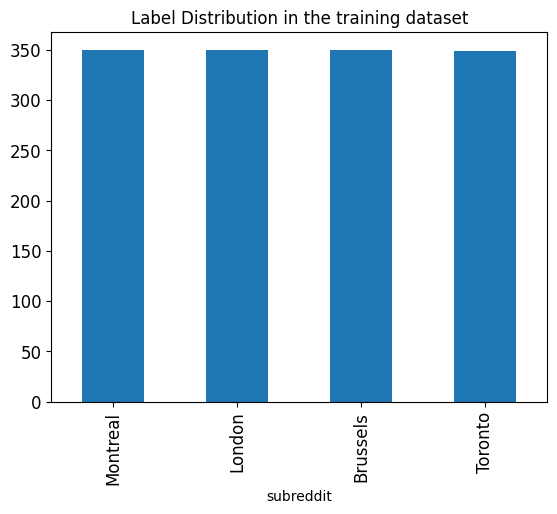

In [7]:
# Show distribution of examples per class 
df = pd.DataFrame(training_data)
# Count the number of samples for each label
label_counts = df['subreddit'].value_counts()
# Plot the distribution
label_counts.plot(kind='bar', title='Label Distribution in the training dataset', fontsize=12)

#### Text lenght distribution ####

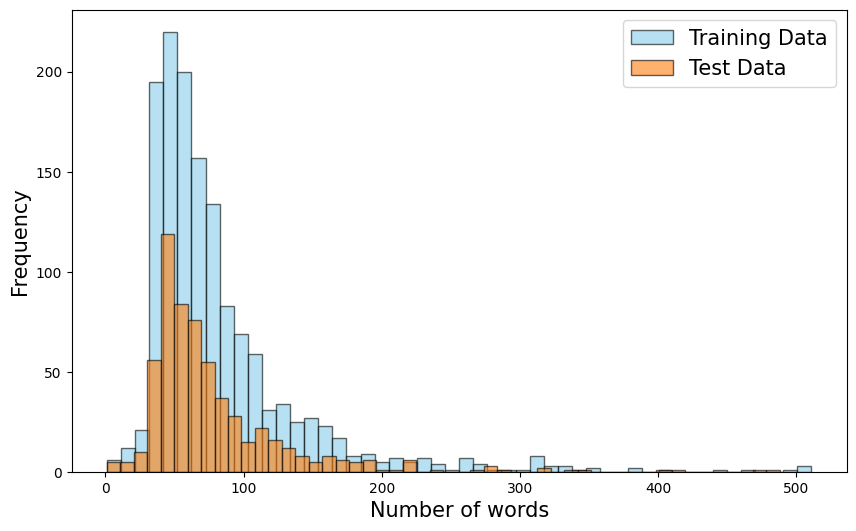

In [8]:
# Calculate the length of each text (in words) for both training and test datasets
text_lengths_train = x_train.apply(lambda x: len(x.split()))
text_lengths_test = x_test.apply(lambda x: len(x.split()))

# Plot both histograms on the same figure
plt.figure(figsize=(10, 6))

# Plot the training dataset histogram
plt.hist(text_lengths_train, bins=50, color='skyblue', edgecolor='black', alpha=0.6, label='Training Data')

# Plot the test dataset histogram
plt.hist(text_lengths_test, bins=50, color='tab:orange', edgecolor='black', alpha=0.6, label='Test Data')

# Add labels and title
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
# Add legend
plt.legend(fontsize=15)

# Show the plot
plt.show()

#### Most distinctive words  analysis ####

In [ ]:
def classify_language(comment):
    language, _ = langid.classify(comment)
    return 'Montreal (english)' if language == 'en' else 'Montreal (french)' if language == 'fr' else 'Montreal (english)'

# Modify the labels for comments in the Montreal class
y_train_mtl_distinct = []  # To hold modified labels

for comment, label in zip(x_train, y_train):
    if label == 'Montreal':
        language = classify_language(comment)
        y_train_mtl_distinct.append(language)
    else:
        y_train_mtl_distinct.append(label)

def plot_most_distinctive_words_frequency(top_n_plot, texts_train, y_train, top_n_selected, plots=True):
    unique_labels = sorted(set(y_train))  # Get unique classes
    label_texts = {label: [] for label in unique_labels}  # Dictionary to hold texts per class

    # Separate texts by label
    for text, label in zip(texts_train, y_train):
        label_texts[label].append(text)

    # Fit CountVectorizer with the custom tokenizer
    vectorizer = CountVectorizer(
        token_pattern=r'\b[a-zA-Z]{2,}\b',
        stop_words=stopwords_list,
        tokenizer=LemmaTokenizer(stopwords=stopwords_list),
        strip_accents="unicode"
    )
    
    vectorizer.fit(texts_train)
    feature_names = vectorizer.get_feature_names_out()

    # Initialize a dictionary to store word frequencies per class
    word_frequencies = {label: np.zeros(len(feature_names)) for label in unique_labels}

    # Calculate word frequencies for each word in each class
    for label in unique_labels:
        count_matrix = vectorizer.transform(label_texts[label])
        word_frequencies[label] = np.array(count_matrix.sum(axis=0)).flatten()

    # List to hold the top distinctive words across all classes
    all_distinctive_words = []

    if plots:
        # Set up the figure with subplots
        n_labels = len(unique_labels)
        n_cols = 2  # Number of columns for subplots
        n_rows = (n_labels + n_cols - 1) // n_cols  # Calculate number of rows required
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 10))  # Adjust grid size
        axes = axes.flatten()  # Flatten axes array for easy indexing

    for i, label in enumerate(unique_labels):
        # Calculate distinctiveness by comparing word frequency of this class to the average in other classes
        other_classes = [lbl for lbl in unique_labels if lbl != label]

        if label == "montreal_english":
            avg_freq_other_classes = np.mean([word_frequencies[other_label] for other_label in other_classes if other_label != "montreal_french"], axis=0)
        elif label == "montreal_french":
            avg_freq_other_classes = np.mean([word_frequencies[other_label] for other_label in other_classes if other_label != "montreal_english"], axis=0)
        else:
            avg_freq_other_classes = np.mean([word_frequencies[other_label] for other_label in other_classes], axis=0)

        # Calculate distinctiveness score (frequency in this class minus average frequency in other classes)
        distinctiveness_scores = word_frequencies[label] - avg_freq_other_classes

        # Get the indices of the top N distinctive words
        if label == "montreal_english" or label == "montreal_french":
            top_n_selected_mtl = int(top_n_selected*0.6)
            top_indices = np.argsort(distinctiveness_scores)[-top_n_selected_mtl:][::-1]  # Indices of top N scores in descending order
        else:
            top_indices = np.argsort(distinctiveness_scores)[-top_n_selected:][::-1]  # Indices of top N scores in descending order

        # Select the top N distinctive words and their scores
        distinctive_words = [feature_names[idx] for idx in top_indices]
        distinctive_scores = [distinctiveness_scores[idx] for idx in top_indices]

        # Extend the all_distinctive_words list with the current class's words
        all_distinctive_words.extend(distinctive_words)

        if plots:
            ax = axes[i]
            ax.barh(distinctive_words[0:top_n_plot], distinctive_scores[0:top_n_plot], color='skyblue')
            ax.set_xlabel("Frequency Difference")
            ax.set_title(f"Top {top_n_plot} distinctive words for class '{label}'")
            ax.invert_yaxis()  # Invert y-axis to have the most distinctive words on top
            # Adjust layout and show the figure
    if plots:
        for j in range(i + 1, len(axes)):
            axes[j].axis('off')
        plt.tight_layout()
        plt.show()

    # Return the merged list of top distinctive words across all classes
    return list(set(all_distinctive_words))  # Convert to set to remove duplicates and back to list


plot_most_distinctive_words_frequency(15, x_train, y_train, top_n_selected=500, plots=True)


KeyboardInterrupt: 

#### PCA Analysis ####

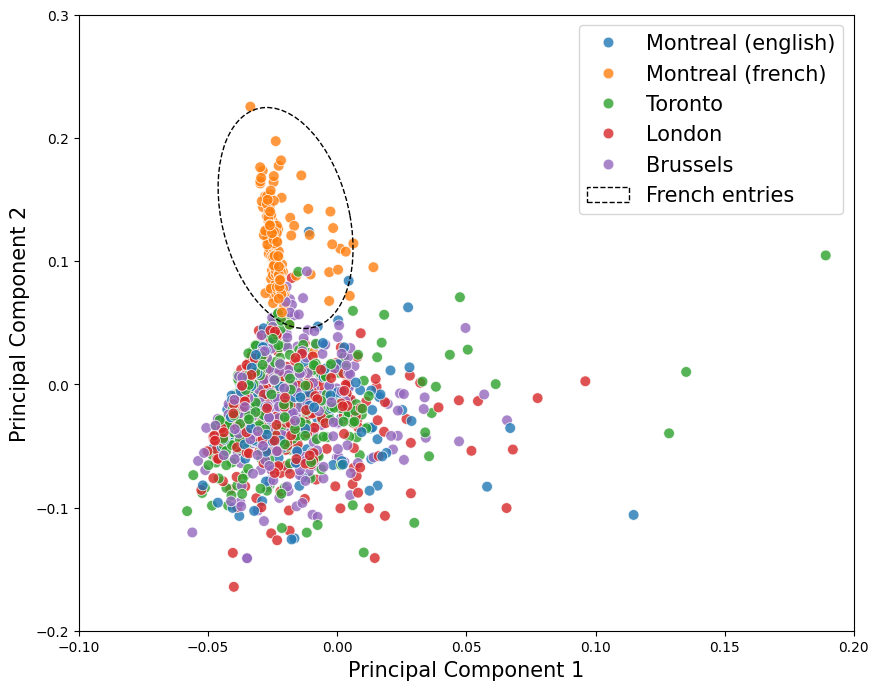

In [ ]:
from matplotlib.patches import Ellipse

# PCA Analysis with TF-IDF vectorization
vectorizer = TfidfVectorizer(
    lowercase=True,
    tokenizer=LemmaTokenizer(stopwords=stopwords_list)
)
X_tfidf = vectorizer.fit_transform(x_train)

# Use PCA to reduce dimensionality to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_tfidf)

# Plot the PCA result with labels
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_train_mtl_distinct, palette='tab10', s=60, alpha=0.8)

# Define the ellipse properties
ellipse = Ellipse(
    xy=(-0.02, 0.135),  # Center of the ellipse (mean of the points)
    width=0.18,  # Width of the ellipse
    height=0.05,  # Height of the ellipse
    angle=95,  # Rotation angle of the ellipse
    edgecolor='black',  # Color of the ellipse edge
    facecolor='none',  # No fill inside the ellipse
    lw=1, 
    linestyle='--',
    label="French entries"
)

# Add the ellipse to the plot
plt.gca().add_patch(ellipse)

# Add titles and labels
plt.xlabel("Principal Component 1", fontsize=15)
plt.xlim(-0.1, 0.2)
plt.ylim(-0.2, 0.3)
plt.ylabel("Principal Component 2", fontsize=15)
plt.legend(loc='best', fontsize=15)
plt.show()



## 6. Vectorization of the Training Texts (BNB)



To utilize the texts in machine learning models, it is essential to convert them into a vectorized format. Below are several methods available for encoding texts as vectors.


### <span style="color: #FF9800;">Codes</span> ###

#### Hyperparameter for BNB #####

In [ ]:
def grid_search_naive_bayes_distinctiveness(x_train, y_train, max_features_list, y_train_mtl, k_cv=10):
    best_accuracy = 0
    best_params = {}
    results = []
    
    # Iterate over all max_features
    for max_features in (max_features_list):
        print(f"Testing max_features={max_features}")

        vocab = np.unique(np.array(plot_most_distinctive_words_frequency(20, x_train, y_train_mtl, top_n_selected=max_features, plots=False)))

        vectorizer = CountVectorizer(
            binary=True, # vectorized vector must be binary for Naive Bayes
            lowercase=True, # words must be in lowercases
            vocabulary=vocab
        )

        x_train_distinctiveness = vectorizer.fit_transform(x_train)
        
        classifier = NaiveBayesClassifier(laplace_alpha=1, unique_labels=unique_labels)
        time_start = time.time()
        mean_accuracy, mean_std, mean_training_accuracy, mean_accu_per_class = classifier.k_fold_cross_validation(k_cv, x_train_distinctiveness.todense(), y_train, print_info=False)
        mean_computation_time = 1/k_cv * (time.time() - time_start)
        
        # Calculate mean accuracy across folds
        results.append((max_features, mean_accuracy, mean_std, mean_training_accuracy, mean_computation_time, mean_accu_per_class))
        
        # Update best params if current mean accuracy is the highest
        if mean_accuracy > best_accuracy:
            best_accuracy = mean_accuracy
            best_params = {'max_features': max_features}
    
    # Output the results of the grid search
    print("\nGrid search results:")
    for max_features, accuracy, std, mean_training_accuracy, mean_computation_time, mean_accu_per_class in results:
        print(f"max_features: {max_features} -> Mean Accuracy: {accuracy:.4f}")
    max_features_values = [result[0] for result in results]
    mean_accuracies = [result[1] for result in results]
    mean_stds = [result[2] for result in results]
    mean_training_accuracies = [result[3] for result in results]
    mean_accu_per_class = np.array([result[5] for result in results])


    # Create a new figure for plotting
    plt.figure(figsize=(10, 6))

    plt.plot(max_features_values, mean_training_accuracies, label='Training Accuracy', color='g', marker='o', linewidth=2)
    
    # Add labels and title
    plt.xlabel("Max features per class labels", fontsize=15)
    plt.ylabel("Mean accuracy", color='k', fontsize=15)
    plt.title("Feature selection using distinctiveness scoring")
    plt.legend(loc='upper left')

    # Create a secondary y-axis for validation accuracy
    ax2 = plt.gca().twinx()
    ax2.plot(max_features_values, mean_accuracies, label='Validation Accuracy', color='b', marker='o', linewidth=2)
    ax2.plot(max_features_values, mean_accu_per_class[:,0], label='Validation Accuracy - Brussels', color='tab:orange', marker='+', linestyle='--')
    ax2.plot(max_features_values, mean_accu_per_class[:,1], label='Validation Accuracy - London', color='tab:red', marker='+', linestyle='--')
    ax2.plot(max_features_values, mean_accu_per_class[:,2], label='Validation Accuracy - Montreal', color='tab:purple', marker='+', linestyle='--')
    ax2.plot(max_features_values, mean_accu_per_class[:,3], label='Validation Accuracy - Toronto', color='tab:grey', marker='+', linestyle='--')


    ax2.set_ylabel("Validation Accuracy", fontsize=15)
    ax2.tick_params(axis='y')

    # Show both legends
    ax2.legend(loc='lower right')

    # Show the plot
    plt.show()
    print(f"\nBest parameter: max_features={best_params['max_features']} with accuracy={best_accuracy:.4f}")
    
    return best_params, best_accuracy


def grid_search_naive_bayes_mutual_information(x_train, y_train, max_features_list, k_cv=10):
    best_accuracy = 0
    best_params = {}
    results = []
    
    # Iterate over all max_features
    for max_features in (max_features_list):
        print(f"Testing max_features={max_features}")

        vectorizer = CountVectorizer(
            binary=True, # vectorized vector must be binary for Naive Bayes
            lowercase=True, # words must be in lowercases
            tokenizer=LemmaTokenizer(stopwords=stopwords_list)
        )

        x_train = vectorizer.fit_transform(x_train)
        x_train_new = SelectKBest(mutual_info_classif, k=max_features).fit_transform(x_train, y_train)
        
        classifier = NaiveBayesClassifier(laplace_alpha=1, unique_labels=unique_labels)
        time_start = time.time()
        mean_accuracy, mean_std, mean_training_accuracy, mean_accu_per_class = classifier.k_fold_cross_validation(k_cv, x_train_new.todense(), y_train, print_info=False)
        mean_computation_time = 1/k_cv * (time.time() - time_start)
        
        # Calculate mean accuracy across folds
        results.append((max_features, mean_accuracy, mean_std, mean_training_accuracy, mean_computation_time, mean_accu_per_class))
        
        # Update best params if current mean accuracy is the highest
        if mean_accuracy > best_accuracy:
            best_accuracy = mean_accuracy
            best_params = {'max_features': max_features}
    
    # Output the results of the grid search
    print("\nGrid search results:")
    for max_features, accuracy, std, mean_training_accuracy, mean_computation_time, mean_accu_per_class in results:
        print(f"max_features: {max_features} -> Mean Accuracy: {accuracy:.4f}")
    max_features_values = [result[0] for result in results]
    mean_accuracies = [result[1] for result in results]
    mean_stds = [result[2] for result in results]
    mean_training_accuracies = [result[3] for result in results]
    mean_accu_per_class = np.array([result[5] for result in results])


    # Create a new figure for plotting
    plt.figure(figsize=(10, 6))

    plt.plot(max_features_values, mean_training_accuracies, label='Training Accuracy', color='g', marker='o', linewidth=2)
    
    # Add labels and title
    plt.xlabel("Max features per class labels", fontsize=15)
    plt.ylabel("Mean accuracy", color='k', fontsize=15)
    plt.title("Feature selection using mutual information scoring")
    plt.legend(loc='upper left')

    # Create a secondary y-axis for validation accuracy
    ax2 = plt.gca().twinx()
    ax2.plot(max_features_values, mean_accuracies, label='Validation Accuracy', color='b', marker='o', linewidth=2)
    ax2.plot(max_features_values, mean_accu_per_class[:,0], label='Validation Accuracy - Brussels', color='tab:orange', marker='+', linestyle='--')
    ax2.plot(max_features_values, mean_accu_per_class[:,1], label='Validation Accuracy - London', color='tab:red', marker='+', linestyle='--')
    ax2.plot(max_features_values, mean_accu_per_class[:,2], label='Validation Accuracy - Montreal', color='tab:purple', marker='+', linestyle='--')
    ax2.plot(max_features_values, mean_accu_per_class[:,3], label='Validation Accuracy - Toronto', color='tab:grey', marker='+', linestyle='--')


    ax2.set_ylabel("Validation Accuracy", fontsize=15)
    ax2.tick_params(axis='y')

    # Show both legends
    ax2.legend(loc='lower right')

    # Show the plot
    plt.show()
    print(f"\nBest parameter: max_features={best_params['max_features']} with accuracy={best_accuracy:.4f}")
    
    return best_params, best_accuracy

#grid_search_naive_bayes_distinctiveness(x_train, y_train, np.arange(50, 2000, 200), y_train_mtl_distinct, k_cv=10)
#grid_search_naive_bayes_mutual_information(x_train, y_train, np.arange(50, 4000, 200), k_cv=10)

## 7. K-fold cross validation (BNB + Distinctiveness)


In [ ]:
k_cv = 10

vocab = np.unique(np.array(plot_most_distinctive_words_frequency(20, x_train, y_train_mtl_distinct, top_n_selected=650, plots=False)))

vectorizer = CountVectorizer(
    binary=True, # vectorized vector must be binary for Naive Bayes
    lowercase=True, # words must be in lowercases
    vocabulary=vocab
)

x_train_distinctiveness = vectorizer.fit_transform(x_train)
print(f"Feature selection based on distinctiveness ranking: vectorized training dataset has {x_train_distinctiveness.shape[1]} tokens/features")

        
classifier = NaiveBayesClassifier(laplace_alpha=1, unique_labels=unique_labels)

time_start = time.time()
mean_accuracy, mean_std, mean_training_accuracy, mean_accu_per_class = classifier.k_fold_cross_validation(k_cv, x_train_distinctiveness.todense(), y_train, print_info=False)
mean_computation_time = (time.time() - time_start)
print(f'Mean accuracy (training) accross {k_cv}-fold cross validation : {mean_training_accuracy}')
print(f'Mean variance of validation accuracy accross {k_cv}-fold cross validation : {mean_std}')
print(f'Mean validation accuracy accross {k_cv}-fold cross validation : {mean_accuracy}')
print(f'Mean validation accuracy accross {k_cv}-fold cross validation for class Brussels : {mean_accu_per_class[0]}')
print(f'Mean validation accuracy accross {k_cv}-fold cross validation for class London : {mean_accu_per_class[1]}')
print(f'Mean validation accuracy accross {k_cv}-fold cross validation for class Montreal : {mean_accu_per_class[2]}')
print(f'Mean validation accuracy accross {k_cv}-fold cross validation for class Toronto : {mean_accu_per_class[3]}')
print(f'Computation time  accross {k_cv}-fold cross validation: {mean_computation_time}')


/home/clatimie/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/clatimie/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'etaient', 'etais', 'etait', 'etant', 'etante', 'etantes', 'etants', 'ete', 'etee', 'etees', 'etes', 'etiez', 'etions', 'eumes', 'eutes', 'fume', 'futes', 'meme', 'might', 'must', 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


Feature selection based on distinctiveness ranking: vectorized training dataset has 2727 tokens/features
Mean accuracy (training) accross 10-fold cross validation : 0.868006737467169
Mean variance of validation accuracy accross 10-fold cross validation : 0.045002118492199907
Mean validation accuracy accross 10-fold cross validation : 0.7119093914057943
Mean validation accuracy accross 10-fold cross validation for class Brussels : 0.8003380210915714
Mean validation accuracy accross 10-fold cross validation for class London : 0.7885601756571026
Mean validation accuracy accross 10-fold cross validation for class Montreal : 0.5092901811267064
Mean validation accuracy accross 10-fold cross validation for class Toronto : 0.7417205036797464
Computation time  accross 10-fold cross validation: 3.569556474685669


## 8. K-fold cross validation (BNB + Mutual Information)


In [ ]:
k_cv = 10
vectorizer = CountVectorizer(
            binary=True, # vectorized vector must be binary for Naive Bayes
            lowercase=True, # words must be in lowercases
            tokenizer=LemmaTokenizer(stopwords=stopwords_list)
        )

x_train = vectorizer.fit_transform(x_train)
selector = SelectKBest(mutual_info_classif, k=2850)
x_train_mi = selector.fit_transform(x_train, y_train)
print(f"Feature selection based on mutual information ranking: vectorized training dataset has {x_train_mi.shape[1]} tokens/features")

        
classifier = NaiveBayesClassifier(laplace_alpha=1, unique_labels=unique_labels)

time_start = time.time()
mean_accuracy, mean_std, mean_training_accuracy, mean_accu_per_class = classifier.k_fold_cross_validation(k_cv, x_train_mi.todense(), y_train, print_info=False)
mean_computation_time = (time.time() - time_start)
print(f'Mean accuracy (training) accross {k_cv}-fold cross validation : {mean_training_accuracy}')
print(f'Mean variance of validation accuracy accross {k_cv}-fold cross validation : {mean_std}')
print(f'Mean validation accuracy accross {k_cv}-fold cross validation : {mean_accuracy}')
print(f'Mean validation accuracy accross {k_cv}-fold cross validation for class Brussels : {mean_accu_per_class[0]}')
print(f'Mean validation accuracy accross {k_cv}-fold cross validation for class London : {mean_accu_per_class[1]}')
print(f'Mean validation accuracy accross {k_cv}-fold cross validation for class Montreal : {mean_accu_per_class[2]}')
print(f'Mean validation accuracy accross {k_cv}-fold cross validation for class Toronto : {mean_accu_per_class[3]}')
print(f'Computation time  accross {k_cv}-fold cross validation: {mean_computation_time}')

classifier.fit(x_train_mi.todense(), y_train)

x_test = vectorizer.transform(x_test)
x_test_mi = selector.transform(x_test)

y_pred = classifier.predict(x_test_mi.todense()) 

y_pred = y_pred.flatten() if len(y_pred.shape) > 1 else y_pred

# Construct the DataFrame and save to CSV
results_df = pd.DataFrame({
    'id': range(len(y_pred)),
    'subreddit': y_pred
})

# Save predictions to CSV
results_df.to_csv("../output/submissions_mutual_information_bnb.csv", index=False)
print("Predictions saved to ../output/submissions_mutual_information_bnb.csv")





/home/clatimie/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Feature selection based on mutual information ranking: vectorized training dataset has 2850 tokens/features
Mean accuracy (training) accross 10-fold cross validation : 0.8590310608655933
Mean variance of validation accuracy accross 10-fold cross validation : 0.04346068097414368
Mean validation accuracy accross 10-fold cross validation : 0.749863892669648
Mean validation accuracy accross 10-fold cross validation for class Brussels : 0.8170787233493352
Mean validation accuracy accross 10-fold cross validation for class London : 0.8835763419696704
Mean validation accuracy accross 10-fold cross validation for class Montreal : 0.5223190772951375
Mean validation accuracy accross 10-fold cross validation for class Toronto : 0.7713861288476179
Computation time  accross 10-fold cross validation: 3.529296636581421
Predictions saved to ../output/submissions_mutual_information_bnb.csv
